In [85]:
import os
import random
import json
import pickle

import tensorflow as tf
import kagglehub as kh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
tf.random.set_seed(42)

In [87]:
# Import CSV
df = pd.read_csv('ISS_rotated.csv')
del df["Unnamed: 0"]

In [88]:
df.head()
# print(type(df['location']))

,ImageID,distance,location
0,0,351,"[152, 230]"
1,1,372,"[278, 276]"
2,2,488,"[262, 385]"
3,3,308,"[260, 78]"
4,4,67,"[336, 272]"


In [89]:
n_imgs = len(df)
n_imgs

10000

In [90]:
# plt.hist(df['distance'], bins=30)
# plt.show()

In [91]:
img_width = img_height = 512
batch_size = 32

In [92]:
# Define path
path = "/Users/jacobbalek/Documents/HackAI2025/HackAI2025"

image_paths = []
for f in os.listdir(os.path.join(path, 'Rotated_ISS_imgs')):
    if f.startswith('.') or '.png' not in f:
        continue
    image_paths.append(os.path.join(path, 'Rotated_ISS_imgs', f))
len(image_paths)


10000

In [93]:
# Get distances and locations from csv
distances = df.get('distance').tolist()
locations = df.get('location').tolist()

distances[:5]

[351, 372, 488, 308, 67]

In [94]:
image_paths.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

In [95]:
combined_distances = list(zip(image_paths, distances))
combined_locations = list(zip(image_paths, locations))
random.Random(42).shuffle(combined_distances) # SEED
random.Random(42).shuffle(combined_locations) # SEED

In [96]:
image_paths_distances, distances = zip(*combined_distances)
image_paths_locations, locations = zip(*combined_locations)

In [97]:
train_split = int(0.7*n_imgs)
val_split = train_split + int(0.1*n_imgs)
test_split = val_split + int(0.2*n_imgs)
print(train_split, val_split, test_split)

7000 8000 10000


In [98]:
# Normalize Data

train_image_paths_distances = np.array(image_paths_distances[:train_split]).flatten()
train_distances = np.array(distances[:train_split]).flatten()
train_image_paths_locations = np.array(image_paths_locations[:train_split]).flatten()
train_locations = locations[:train_split]

val_image_paths_distances = np.array(image_paths_distances[train_split:val_split]).flatten()
val_distances = np.array(distances[train_split:val_split]).flatten()
val_image_paths_locations = np.array(image_paths_locations[train_split:val_split]).flatten()
val_locations = locations[train_split:val_split]

test_image_paths_distances = np.array(image_paths_distances[val_split:test_split]).flatten()
test_distances = np.array(distances[val_split:test_split]).flatten()
test_image_paths_locations = np.array(image_paths_locations[val_split:test_split]).flatten()
test_locations = locations[val_split:test_split]

In [99]:
# Normalizations
train_locations = tuple(map(lambda x: tuple(json.loads(x)), train_locations))
train_locations = np.array(train_locations)
train_locations = (train_locations)/512

# train_locations[:0] = (train_locations[:0])/512 # Normalize X Train
# train_locations[:1] = (train_locations[:1])/512 # Normalize Y  Train

val_locations = tuple(map(lambda x: tuple(json.loads(x)), val_locations))
val_locations = np.array(val_locations)
val_locations = (val_locations)/512 #  Normalize Validation

test_locations = tuple(map(lambda x: tuple(json.loads(x)), test_locations))
test_locations = np.array(test_locations)
test_locations = (test_locations)/512 # Normalize Test

[[0.55078125 0.43554688]
 [0.74609375 0.359375  ]
 [0.5859375  0.6953125 ]
 [0.59765625 0.17773438]
 [0.21875    0.5234375 ]]
7000
[0.55078125 0.74609375 0.5859375  ... 0.32421875 0.23632812 0.5078125 ]
Train


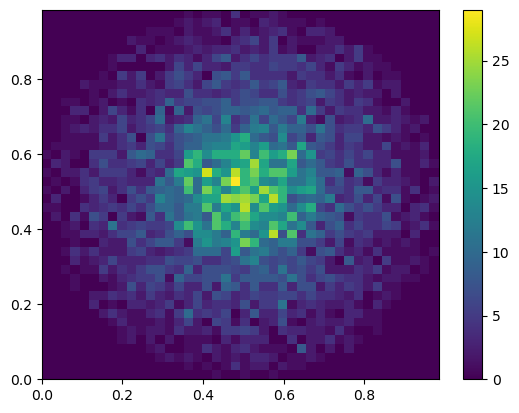

[0.52539062 0.421875   0.22070312 ... 0.55273438 0.40820312 0.35546875]
Test


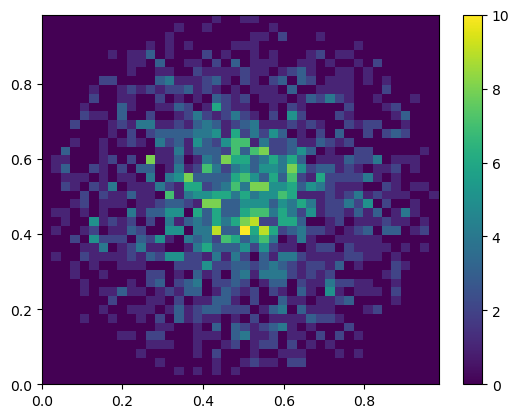

Validation


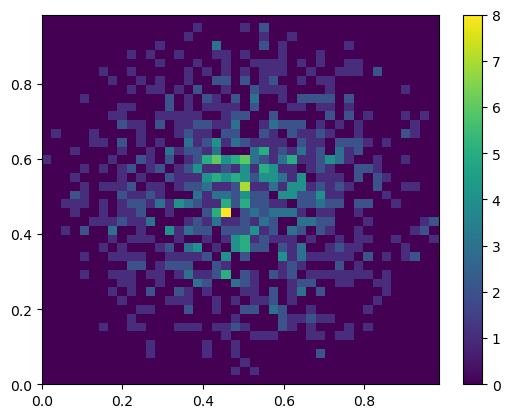

In [100]:
print(train_locations[:5])

locations = np.array(train_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))
print(x)

print("Train")
plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)]) # Train
plt.colorbar()
plt.show()

locations = np.array(test_locations)
x, y = locations[:,0], locations[:, 1]

print(x)

print("Test")
plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)]) # Test
plt.colorbar()
plt.show()

locations = np.array(val_locations)
x, y = locations[:,0], locations[:, 1]

print("Validation")
plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)]) # Validation
plt.colorbar()
plt.show()


In [101]:
train_distances = (train_distances-np.min(train_distances))/(np.max(train_distances)-np.min(train_distances))
val_distances = (val_distances-np.min(val_distances))/(np.max(val_distances)-np.min(val_distances))
test_distances = (test_distances-np.min(test_distances))/(np.max(test_distances)-np.min(test_distances))

In [102]:
print(np.max(train_locations))
print(np.min(train_locations))

1.0
-0.0078125


In [103]:
print(np.max(train_distances))
print(np.min(train_distances))

1.0
0.0


In [104]:
def as_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [105]:
train_image_paths_distances = [as_image(_) for _ in train_image_paths_distances]
val_image_paths_distances = [as_image(_) for _ in val_image_paths_distances]
test_image_paths_distances = [as_image(_) for _ in test_image_paths_distances]

train_image_paths_distances = np.array(train_image_paths_distances)
val_image_paths_distances = np.array(val_image_paths_distances)
test_image_paths_distances = np.array(test_image_paths_distances)

In [106]:
print(train_image_paths_distances.shape)

(7000, 512, 512, 3)


In [107]:
net = tf.keras.applications.MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
net.trainable = False

/Users/jacobbalek/miniconda3/envs/hai/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [108]:
# If this is commented out, it is to reduce file length as this output is long
# net.summary()

In [109]:
# Define SGD Optimizer
from keras.optimizers import SGD

# model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='mean_squared_error')

In [110]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",  # Reduce when val_loss stops improving
    factor=0.5,         # Halve learning rate
    patience=1,          # Wait 2 epochs before reducing
    min_lr=5e-8,         # Minimum learning rate
    min_delta=1e-5,      # Minimum delta needed to trigger ReduceLROnPlateau()
    verbose=1
)

In [111]:
lr = 1e-5
epochs = 50

flatten = net.output
flatten = tf.keras.layers.Flatten()(flatten)

regression = tf.keras.layers.Dense(32, activation='elu')(flatten)
regression = tf.keras.layers.Dense(16, activation='elu')(regression)

# DISTANCE REGRESSION
# left_head = tf.keras.layers.Dense(8, activation='elu')(regression)
left_head = tf.keras.layers.Dense(1, activation='elu', name='distance')(regression)

# LOCATION X REGRESSION
# middle_head = tf.keras.layers.Dense(8, activation='elu')(regression)
middle_head = tf.keras.layers.Dense(1, activation='elu', name='x')(regression)

# LOCATION Y REGRESSION
right_head= tf.keras.layers.Dense(8, activation='elu')(regression)
right_head = tf.keras.layers.Dense(1, activation='elu', name='y')(right_head)

model = tf.keras.Model(inputs=net.input, outputs=(left_head, middle_head, right_head))

losses = { 'distance': 'mean_absolute_error', 'x': 'mean_absolute_error', 'y': 'mean_squared_error' }
loss_weights = { 'distance': 0.4, 'x': 0.3, 'y': 0.3 }

opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss=losses, optimizer=opt, loss_weights=loss_weights)
# model.compile(loss=losses, optimizer=opt)

In [112]:
train_targets = { 'distance': train_distances, 'x': train_locations[:, 0], 'y': train_locations[:, 1] }
test_targets = { 'distance': test_distances, 'x': test_locations[:, 0], 'y': test_locations[:, 1] }
val_targets = { 'distance': val_distances, 'x': val_locations[:, 0], 'y': val_locations[:, 1] }

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_3.keras', monitor='val_loss', save_best_only=True), 
             lr_schedule]
history = model.fit(train_image_paths_distances, train_targets,
                    validation_data = (val_image_paths_distances, val_targets),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 43s 186ms/step - distance_loss: 0.0840 - loss: 0.1448 - x_loss: 0.0498 - y_loss: 0.0110 - val_distance_loss: 0.0599 - val_loss: 0.0882 - val_x_loss: 0.0239 - val_y_loss: 0.0043 - learning_rate: 1.0000e-05
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 177ms/step - distance_loss: 0.0602 - loss: 0.0902 - x_loss: 0.0260 - y_loss: 0.0040 - val_distance_loss: 0.0582 - val_loss: 0.0872 - val_x_loss: 0.0229 - val_y_loss: 0.0059 - learning_rate: 1.0000e-05
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 179ms/step - distance_loss: 0.0557 - loss: 0.0832 - x_loss: 0.0241 - y_loss: 0.0034 - val_distance_loss: 0.0548 - val_loss: 0.0797 - val_x_loss: 0.0211 - val_y_loss: 0.0036 - learning_rate: 1.0000e-05
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - distance_loss: 0.0521 - loss: 0.0774 - x_loss: 0.0220 - y_loss: 0.0032 - val_distance_loss: 0.0483 - val_loss: 0.0700 - val_x_loss: 0.0190 - val_y_loss: 0.0024 - learning_rate: 1.0000e-05
Epoch 5/50
219/219 ━

| Loss  | Total  | Distance | X      | Y      |
|-------|--------|----------|--------|--------|
| Train | 0.0518 | 0.0411   | 0.0086 | 0.0021 |
| Test  | 0.0574 | 0.0454   | 0.0095 | 0.0025 |


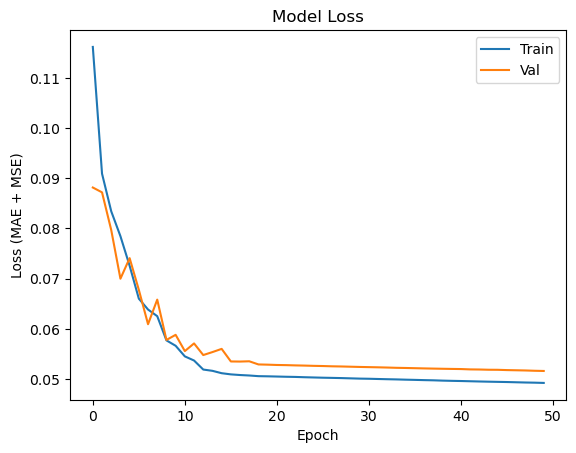

In [113]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MAE + MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('loss3.png')
plt.show()


In [114]:
history.history.keys()

dict_keys(['distance_loss', 'loss', 'x_loss', 'y_loss', 'val_distance_loss', 'val_loss', 'val_x_loss', 'val_y_loss', 'learning_rate'])

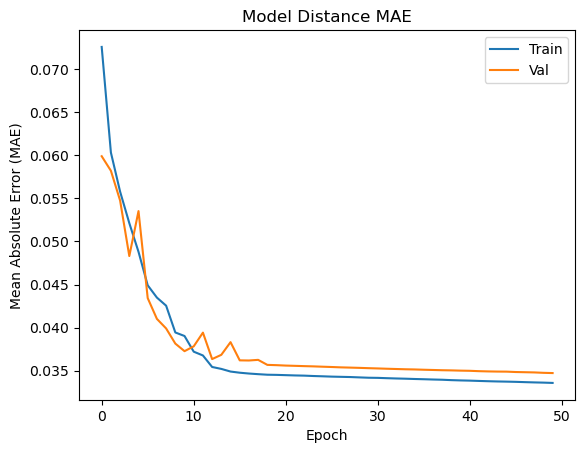

In [115]:
plt.plot(history.history['distance_loss'])
plt.plot(history.history['val_distance_loss'])
plt.title('Model Distance MAE')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
# plt.ylim([0,0.05])
plt.savefig('distancemae3.png')
plt.show()

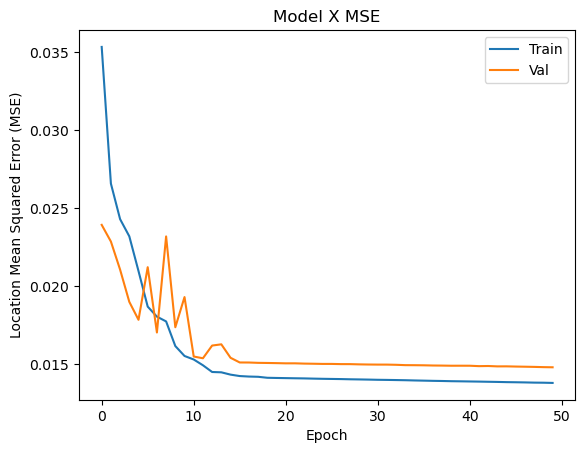

In [116]:
plt.plot(history.history['x_loss'])
plt.plot(history.history['val_x_loss'])
plt.title('Model X MSE')
plt.ylabel('Location Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('mse3.png')
plt.show()

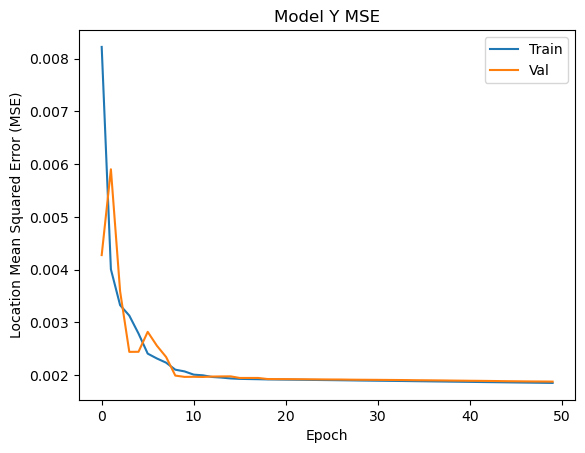

In [117]:
plt.plot(history.history['y_loss'])
plt.plot(history.history['val_y_loss'])
plt.title('Model Y MSE')
plt.ylabel('Location Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('mse3.png')
plt.show()

In [118]:
model.evaluate(test_image_paths_distances, test_targets)

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - distance_loss: 0.0371 - loss: 0.0544 - x_loss: 0.0152 - y_loss: 0.0021


[0.05354790762066841,
 0.036651860922575,
 0.014858853071928024,
 0.002081979298964143]

In [119]:
# Heat Map of guesses of a model

# Extract Predicted Locations
# loaded_model = keras.saving.load_model("distance_issue_model.h5")
# test_image_paths_locations = np.array(image_paths_locations[val_split:test_split]).flatten()
# test_locations = locations[val_split:test_split]



In [120]:
# Heat Map of guesses of a model
predictions = model.predict(test_image_paths_distances)
print(predictions)
print(len(predictions[1]))
print(not np.any(predictions[1]))

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step
(array([[0.7682293 ],
       [0.24840972],
       [0.7537171 ],
       ...,
       [0.5477859 ],
       [0.5075717 ],
       [0.37253055]], dtype=float32), array([[0.5259507 ],
       [0.49940607],
       [0.28293744],
       ...,
       [0.55106956],
       [0.4494119 ],
       [0.3296292 ]], dtype=float32), array([[0.70616055],
       [0.45113724],
       [0.4368544 ],
       ...,
       [0.38423678],
       [0.68793917],
       [0.96623045]], dtype=float32))
2000
False


(2000,)
(2000,)


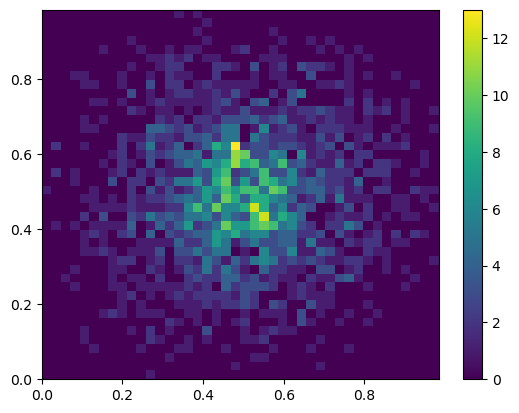

[[0.55078125 0.43554688]
 [0.74609375 0.359375  ]
 [0.5859375  0.6953125 ]
 [0.59765625 0.17773438]
 [0.21875    0.5234375 ]]
2000


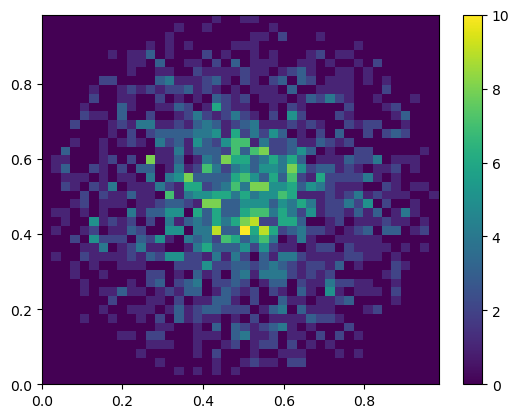

7000


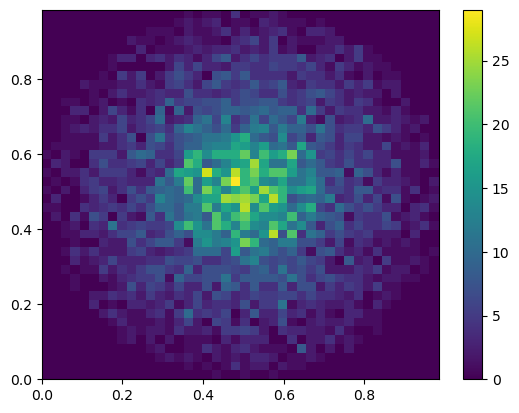

In [121]:
locations = predictions[1:3]
x, y = np.array(locations[0]).flatten(), np.array(locations[1]).flatten()
print(np.array(x).shape)
print(np.array(y).shape)
plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

print(train_locations[:5])

locations = np.array(test_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

locations = np.array(train_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

In [122]:
import pydot, graphviz


In [123]:
from keras.utils import plot_model

# Assuming you have a Keras model
# plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)
